# Import needed modules

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('Modules loaded')

Modules loaded


# Create needed functions

#### **Function to split data into train, valid, test**

In [2]:
# Function to generate data paths with labels
def split_df(csv_dir):
    '''
    This function take csv file and split it into train, valid, and test
    '''

    df = pd.read_csv(csv_dir)

    # train dataframe
    train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

    # valid and test dataframe
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

    return train_df, valid_df, test_df

#### **Function to generate images from dataframe**
**check your variables**

In [3]:
def create_gens(train_df, valid_df, test_df, batch_size):

    ''' This function takes train, validation, and test dataframe and fit them into image data generator, because model takes
        data from image data generator.
        Image data generator converts images into tensors.
        Check your variables'''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)
    train_dir = 'C:/Users/Yuvraj Chugh/Desktop/Deep Learning/plant-pathology-2021-fgvc8/train_images'
    test_dir = 'C:/Users/Yuvraj Chugh/Desktop/Deep Learning/plant-pathology-2021-fgvc8/test_images'
    fpath_col = 'image'
    label_col = 'labels'

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, directory= train_dir, x_col= fpath_col, y_col= label_col, target_size= img_size,
                                            class_mode= 'categorical', color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, directory= train_dir, x_col= fpath_col, y_col= label_col, target_size= img_size,
                                            class_mode= 'categorical', color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, directory= train_dir, x_col= fpath_col, y_col= label_col, target_size= img_size,
                                            class_mode= 'categorical', color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

#### **Function to display data sample**

In [4]:
def show_images(df, data_path):
    '''
    This function take the data generator and show sample of the images
    '''

    sample_df = df.sample(16)
    image_names = sample_df["image"].values
    labels = sample_df["labels"].values
    plt.figure(figsize=(16, 12))
    
    for image_ind, (image_name, label) in enumerate(zip(image_names, labels)):
        plt.subplot(4, 4, image_ind + 1)
        image = cv2.imread(os.path.join(data_path, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    plt.show()

#### **Function to plot value counts for a column in a dataframe**

In [5]:
def plot_labels(df):
    '''
    This function take df and plot labels value counts
    '''

    plt.figure(figsize= (12, 8))
    label_counts = df['labels'].value_counts()
    sns.barplot(x=label_counts.index, y=label_counts)
    plt.xticks(rotation=45)
    plt.show()

#### Function to plot history of training

In [6]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


#### Function to create Confusion Matrix

In [7]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# Model Structure

#### Start Reading Dataset

In [8]:
csv_dir = 'C:/Users/Yuvraj Chugh/Desktop/Deep Learning/plant-pathology-2021-fgvc8/updated_data.csv'
train_path = 'C:/Users/Yuvraj Chugh/Desktop/Deep Learning/plant-pathology-2021-fgvc8/train_images'
try:
    # Get splitted data
    train_df, valid_df, test_df = split_df(csv_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except Exception:
    print('Invalid Input')

Found 10500 validated image filenames belonging to 5 classes.
Found 2250 validated image filenames belonging to 5 classes.
Found 2250 validated image filenames belonging to 5 classes.


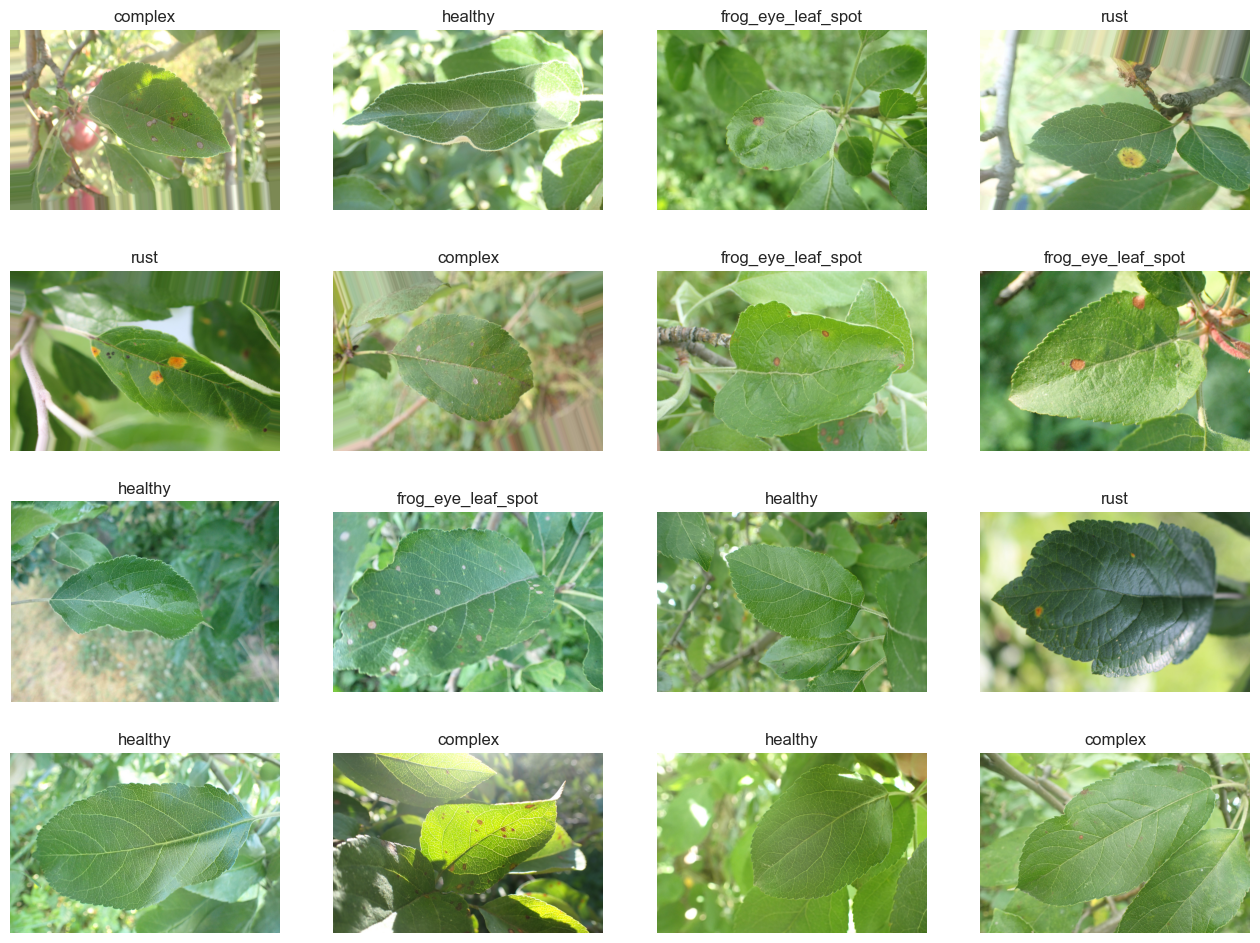

In [9]:
# Display Image Samples
show_images(train_df, train_path)

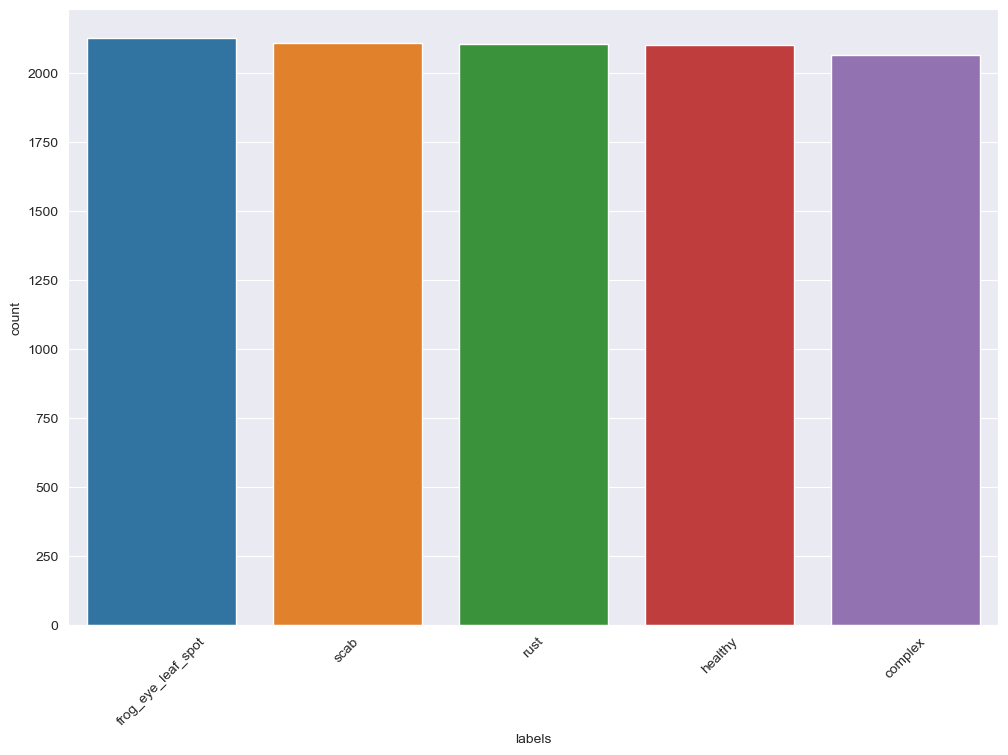

In [10]:
plot_labels(train_df)

#### Generic Model Creation

In [11]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.ResNet50(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
for layer in base_model.layers:
        layer.trainable=False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(64, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'sigmoid')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 23727365 (90.51 MB)
Trainable params: 135557 (529.52 KB)
Non-trainable params: 23591808 (90.00 MB)
_________

#### Train model

In [12]:
history = model.fit(train_gen, epochs = 10, verbose = 1, validation_data = valid_gen, validation_steps = None, shuffle = False)

Epoch 1/10
263/263 [==============================] - 5871s 22s/step - loss: 3.0507 - accuracy: 0.5702 - val_loss: 2.3846 - val_accuracy: 0.7258
Epoch 2/10
263/263 [==============================] - 5517s 21s/step - loss: 2.2166 - accuracy: 0.6910 - val_loss: 1.8989 - val_accuracy: 0.7547
Epoch 3/10
263/263 [==============================] - 6694s 26s/step - loss: 1.7548 - accuracy: 0.7431 - val_loss: 1.5458 - val_accuracy: 0.7676
Epoch 4/10
263/263 [==============================] - 1688s 6s/step - loss: 1.4443 - accuracy: 0.7628 - val_loss: 1.3239 - val_accuracy: 0.7769
Epoch 5/10
263/263 [==============================] - 1735s 7s/step - loss: 1.2350 - accuracy: 0.7804 - val_loss: 1.1645 - val_accuracy: 0.7747
Epoch 6/10
263/263 [==============================] - 1724s 7s/step - loss: 1.0924 - accuracy: 0.7933 - val_loss: 1.0557 - val_accuracy: 0.7884
Epoch 7/10
263/263 [==============================] - 1804s 7s/step - loss: 0.9884 - accuracy: 0.8011 - val_loss: 0.9829 - val_accura

#### Display model performance

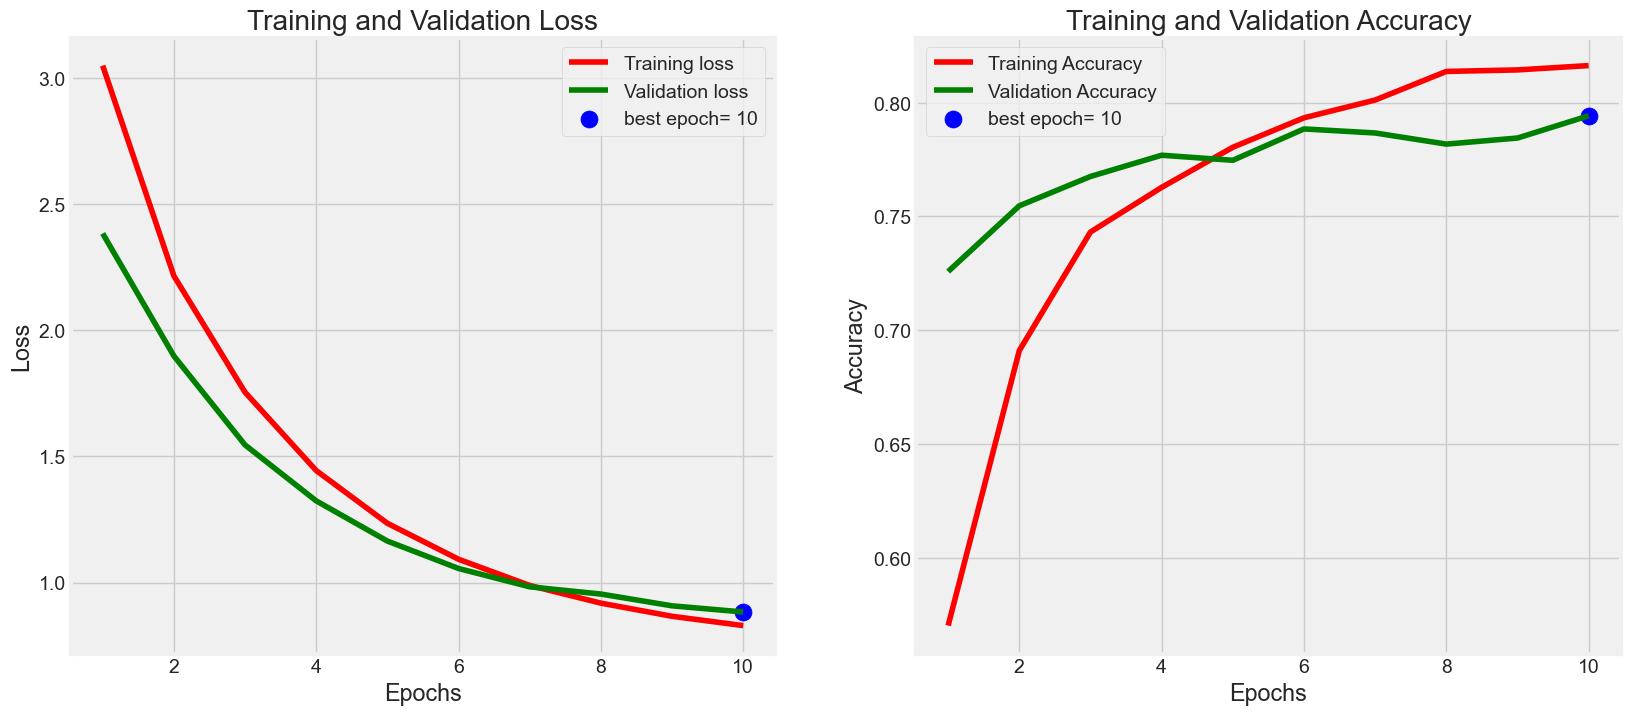

In [13]:
plot_training(history)

### Evaluate model

In [14]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

30/30 [==============================] - 268s 9s/step - loss: 0.8538 - accuracy: 0.7996
Train Loss:  0.6790528297424316
Train Accuracy:  0.8924999833106995
--------------------
Validation Loss:  0.871063232421875
Validation Accuracy:  0.7941666841506958
--------------------
Test Loss:  0.8537666201591492
Test Accuracy:  0.7995555400848389


# Get Predictions

In [15]:
preds = model.predict_generator(test_gen, verbose = 1)
y_pred = np.argmax(preds, axis = 1)
print(y_pred)

30/30 [==============================] - 263s 9s/step
[1 1 1 ... 3 3 1]


#### Confusion Matrics and Classification Report

Confusion Matrix, Without Normalization
[[355  43  13  51  22]
 [ 35 312  40   9  38]
 [  6  16 396   4  26]
 [ 20  23   5 402   8]
 [ 11  36  43   2 334]]
                    precision    recall  f1-score   support

           complex       0.83      0.73      0.78       484
frog_eye_leaf_spot       0.73      0.72      0.72       434
           healthy       0.80      0.88      0.84       448
              rust       0.86      0.88      0.87       458
              scab       0.78      0.78      0.78       426

          accuracy                           0.80      2250
         macro avg       0.80      0.80      0.80      2250
      weighted avg       0.80      0.80      0.80      2250



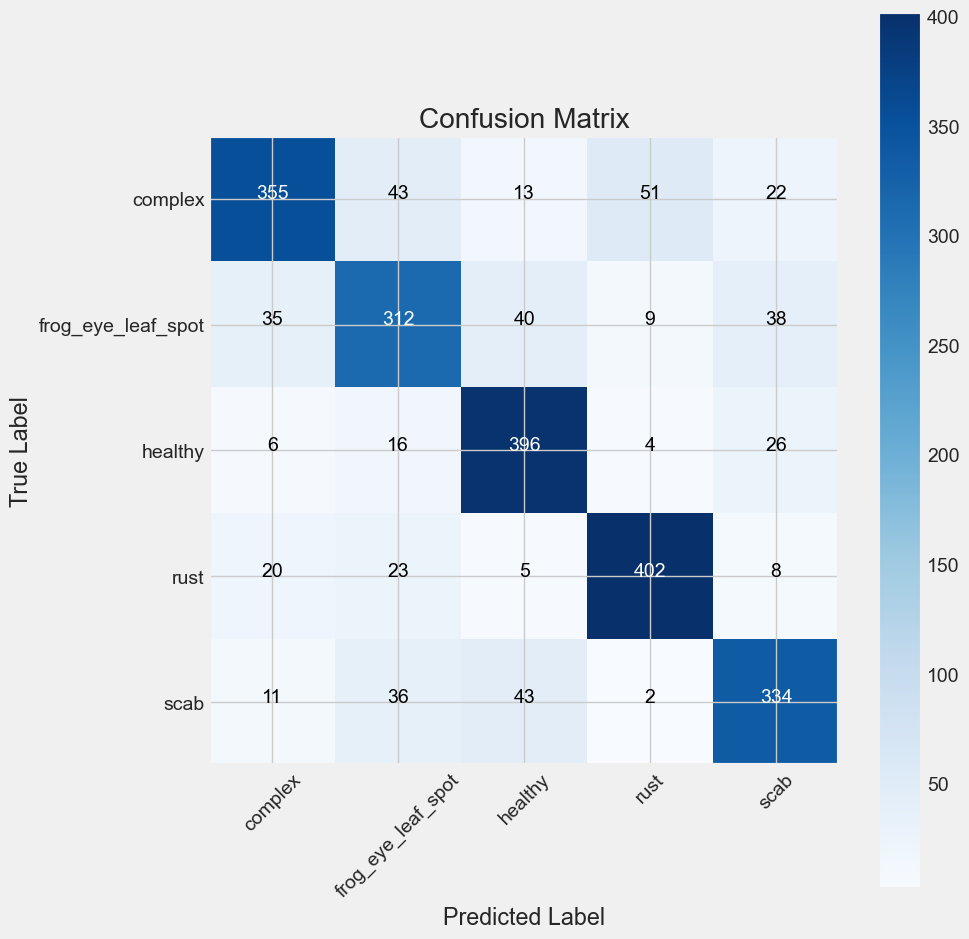

In [16]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

# Save model

In [17]:
model_name = model.input_names[0][:-6]
subject = input('Enter Project Subject')
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as resnet50--79.96.h5
weights were saved as resnet50--weights.h5


### Generate CSV files containing classes indicies & image size 

In [18]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as -class_dict.csv


# Thank You..